# SoundGAN - Generating Audio with a DCGAN with dilated convolutions 

## **Importing modules**

In [1]:
#import all necessary libraries

import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import keras
import scipy
from scipy.io import wavfile
import sklearn
from sklearn.metrics import mean_squared_error
import matplotlib
import random
import sys

tf.__version__

'2.3.0'

In [2]:
## mount drive / this is to save results and to load data if using google colab
#drive.mount("/content/gdrive",force_remount=True)

## **Importing modules for processing of data**

In [3]:
#import my functions for importing/processing/plotting data

import data_import_process
from data_import_process import *

## **Define data source and import/process data**

In [4]:
#define source of data
DATADIR= 'G:/Music/Drumkits/Hats and Rides/'

In [5]:
training_data= import_data(DATADIR,44100)

Kept files with 44100 and deleted 0 files with different sample rate


C:\Users\pasch\Downloads\SoundGAN\data_import_process.py:32: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(path)


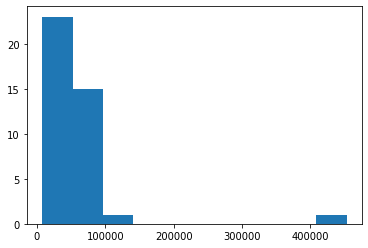

The maximum length of samples for this dataset is 452662 and the average samples per wav file is 52949.45


40

In [6]:
#make histogram of data length before processing
plot_lengths(training_data)
len(training_data)

In [7]:
training_data= preprocess_data(training_data, 7500)

Normalization to values between -1 and +1 completed successfully 

Successfully stripped all beginning and end silences effectively reducing the average samples of the dataset from 52949.45 to 30575.35

Files with length of over 7500 have been successfully removed 

Padding to achieve desired length 



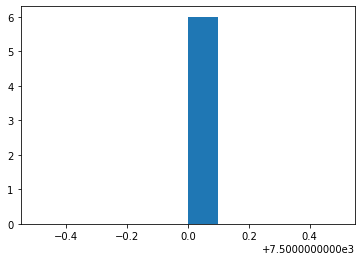

The maximum length of samples for this dataset is 7500 and the average samples per wav file is 7500.0


6

In [8]:
#make histogram of data after processing
plot_lengths(training_data)
len(training_data)

In [9]:
training_data.shape

(6, 7500, 1)

In [10]:
### write back into wav file to see if i made mistakes in processing

scipy.io.wavfile.write("processed_data_sample.wav", 44100, training_data[0])

##WORKS

## **Define Neural Network Model**

In [11]:
#generator model

generator_model= keras.Sequential([
keras.layers.Dense(120*256, input_shape=(120,)),

keras.layers.Reshape((120, 256)),
keras.layers.BatchNormalization(),
keras.layers.ReLU(),

keras.layers.UpSampling1D(size=16),
keras.layers.Conv1D(128, 25, strides=4),
keras.layers.BatchNormalization(),
keras.layers.ReLU(),

keras.layers.UpSampling1D(size=8),
keras.layers.Conv1D(64, 25, strides=4),
keras.layers.BatchNormalization(),
keras.layers.ReLU(),

keras.layers.UpSampling1D(size=8),
keras.layers.Conv1D(32, 25, strides=4),
keras.layers.BatchNormalization(),
keras.layers.ReLU(),

keras.layers.UpSampling1D(size=8),
keras.layers.Conv1D(16, 25, strides=4),
keras.layers.BatchNormalization(),
keras.layers.ReLU(),

keras.layers.UpSampling1D(size=8),
keras.layers.Conv1D(1, 25, strides=4, activation='tanh',padding="same")
])

In [12]:
#discriminator model

discriminator_model= keras.Sequential([
keras.layers.Conv1D(128, 25, strides=4, input_shape=[7500,1]),
keras.layers.LeakyReLU(),
keras.layers.Dropout(0.3),
keras.layers.Conv1D(64, 25, strides=1,dilation_rate=2),
keras.layers.LeakyReLU(),
keras.layers.Dropout(0.3),
keras.layers.Conv1D(64, 25, strides=1,dilation_rate=4),
keras.layers.LeakyReLU(),
keras.layers.Dropout(0.3),
keras.layers.Conv1D(64, 25, strides=1,dilation_rate=8),
keras.layers.LeakyReLU(),
keras.layers.Dropout(0.3),
keras.layers.Flatten(),
keras.layers.Dense(1)
])

In [13]:
## DON'T COMPILE SINCE WE ARE USING A CUSTOM LOSS/OPTIMIZER/TRAINING LOOP

In [14]:
#RESHAPE DATA IN RIGHT SHAPE FOR INPUT INTO MODEL

BATCH_SIZE=2
train_dataset=reshape_data(training_data,7500,BATCH_SIZE,BUFFER_SIZE=training_data.shape[0])

In [15]:
#DEFINE BINARY CROSS-ENTROPY LOSS FOR DISCRIMINATOR AND GENERATOR

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#DEFINE OPTIMIZER AND SET LEARNING RATE

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
noise_dim=120

@tf.function
def train_step(sounds):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_sounds = generator_model(noise, training=True)

      real_output = discriminator_model(sounds, training=True)
      fake_output = discriminator_model(generated_sounds, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [17]:
#define function to generate audio from generator model

def generate_audio(amount,destination,noise_dim,sample_rate):
  #check if destination folder exists, otherwise create
  newpath = destination
  if not os.path.exists(newpath):
    os.makedirs(newpath)

  for i in range(amount):
    #sample and generate sound from latent space
    noise = tf.random.normal([1, noise_dim])
    generated_sound1 = generator_model(noise)
    generated_sound1= generated_sound1[0][:]
    generated_sound1_1 = np.asarray(generated_sound1, np.float32)
    ### write back into wav file to see results
    scipy.io.wavfile.write(str(destination)+str(i)+".wav", sample_rate, generated_sound1_1)

In [18]:
#DEFINE TRAINING LOOP 

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for sound_batch in dataset:
      train_step(sound_batch)

    # generate and save 10 audio clips every 50 epochs
    if (epoch + 1) % 50 == 0:
      generate_audio(10,"generated/epoch{}/".format(epoch + 1),120,44100)

    print ("\r",'Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start), end="         ")

In [19]:
train(train_dataset, 50)

 Time for epoch 50 is 2.9516680240631104 sec         

### Generate Audio

In [20]:
#GENERATE EXAMPLES WHEN DONE WITH MODEL

generate_audio(100,"generated/epoch{}/".format(50),120,44100)

## Check if Network is simply memorizing the training data

In [21]:
## DECLARE PATH TO GENERATED DATA THAT YOU WISH TO COMPARE
DATADIR="generated/epoch50/"

In [22]:
generated_data=import_data(DATADIR,44100)

Kept files with 44100 and deleted 0 files with different sample rate


In [23]:
#select audio file to compare
file_to_compare= generated_data[0]

In [27]:
## THIS SAVES THE GENERATED DATA AND THE MOST SIMILAR TRAINING DATA. 
## THIS NEEDS TO BE COMPARED MANUALLY TO VERIFY IF MODEL IS MEMORIZING

def export_similar(generated_file,training_data):
    x=[]
    x.append(generated_file)
    x.append(training_data[find_most_similar_audio(generated_file,training_data)])
    write_wav_data(x,'/similaraudio/')

In [28]:
export_similar(file_to_compare,training_data)

The most similar audio in the dataset is number 2 (index nr. 1) and has an mse of 0.012512419
